In [140]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import ckey, skey           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [2]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=ckey, client_secret=skey)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [6]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                    # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

germany_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up main dataframe with data from FIRST file
string = str(glob.glob(path)[0])                                 # in the folder.
germany_tracks_df['Year'] = ""
germany_tracks_df['Month'] = ""
year_month = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
for index,row in germany_tracks_df.iterrows():
    germany_tracks_df.loc[index, "Year"] = year_month[0][0]                   # file name, and sets up new columns called 'Year'
    germany_tracks_df.loc[index, "Month"] = year_month[0][1]                  # and 'Month' with that info. 

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        temp_df['Year'] = ""
        temp_df['Month'] = ""
        year_month = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        for index,row in germany_tracks_df.iterrows():
            temp_df[['Year']] = year_month[0][0]
            temp_df[['Month']] = year_month[0][1] 
        germany_tracks_df = pd.concat([germany_tracks_df,          # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.       
                                                 
germany_tracks_df = germany_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month

germany_df = pd.DataFrame(germany_tracks_df)                      # You should get 4,800 rows (24 months x 200 
germany_df

,Position,Track Name,Artist,Streams,URL,Year,Month
0,1,Hobby Hobby,MERO,7774110,https://open.spotify.com/track/260R90ctQ1SiPax...,2019,01
1,2,DODI,Shindy,3942856,https://open.spotify.com/track/63THFs9ovzO3WQs...,2019,01
2,3,Benzema,Capital Bra,3592118,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,2019,01
3,4,Wenn die Sonne untergeht,Azet,3366951,https://open.spotify.com/track/23N0z3XkwS2ErcN...,2019,01
4,5,Warnung,Kontra K,3063451,https://open.spotify.com/track/3OgD9c7c6GhEWUK...,2019,01
...,...,...,...,...,...,...,...
195,196,Watermelon Sugar,Harry Styles,567709,https://open.spotify.com/track/6UelLqGlWMcVH1E...,2020,12
196,197,Come & Go (with Marshmello),Juice WRLD,565960,https://open.spotify.com/track/2Y0wPrPQBrGhoLn...,2020,12
197,198,Hello (feat. A Boogie Wit da Hoodie),Pop Smoke,565908,https://open.spotify.com/track/2r6OAV3WsYtXuXj...,2020,12
198,199,Shake Up Christmas,Train,565757,https://open.spotify.com/track/1NghHeg0wE32eBY...,2020,12


In [7]:
# Get Track IDs

track_names = germany_df['Track Name'].to_list()           # Set up list of tacks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)

Hobby Hobby song ID : 0dmrz4V5kiezQAqQ3VqGob
DODI song ID : 45h4w81P5iJJTSeR0jJUQ8
Benzema song ID : 0gyO8zq1Hw5GTQ33EXcc40
Wenn die Sonne untergeht song ID : 23N0z3XkwS2ErcNKsgCWAb
Warnung song ID : 64SCQtbRtmO28ks1QhS3w5
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
JAJA song ID : 1FmOWhvlAerXKE8xCZUOgy
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Baller los song ID : 1uNzKXVNwq7jwV0rhjXqLB
#niemalsantäuschen song ID : 4mI0sGmXHviRF9QbY4bfq7
HaifischNikez Allstars song ID : 0kLA41xkWzzYzMIEGFuDkP
Tausend Tattoos song ID : 1rGZd7EVl4aOClpzDLNPwy
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Lelele song ID : 4sd72yN6saIBXtNzQhgRf7
Standard (feat. Trettmann, Gringo, Ufo361 & Gzuz) song ID : 5WxzuqQCeCsFlUEStzTp3K
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Shem Shem & Sex song ID : 6sOEMx5vECgoCAyIU9eb7b
500 PS song ID : 4UOXo3xWnxYdTf3sFyRaUG
Speechless (feat. Erika Sirola) song ID : 1rCcsYnmqbMYdkG7kS9GC5
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm


In My Feelings song ID : 2G7V7zsVDxg1yRsu7Ew9RJ
Startender (feat. Offset and Tyga) song ID : 0jAfdqv18goRTUxm3ilRjb
Von Party zu Party song ID : 4h6UIDvGWTYZvu4BLf2GpO
Africa song ID : 2374M0fQpWi3dLnB54qaLX
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Back To You - From 13 Reasons Why – Season 2 Soundtrack song ID : 4hQ6UGyWQIGJmHSo0J88JW
TGV song ID : 3iq27LtUMru3aYFjxv7qak
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Polaroid song ID : 49COPp81lGS9Hl9OwKlsKl
Lose Yourself - Soundtrack Version song ID : 1a3xfVZyJnlKn4t65ccBbp
Power Over Me song ID : 4tViDtaHuSLnh7HVJTrKhs
Havana (feat. Young Thug) song ID : 1rfofaqEpACxVEHIZBJe6W
Guap Gang song ID : 6WkbQW89dlU7z6Tr99P0nl
Oder nicht song ID : 34W06Vcl2mfQOsdOFV43Ao
Wann dann song ID : 1cshW2enZKomOOLRXw6C77
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
High On Life (feat. Bonn) song ID : 4ut5G4rgB1ClpMTMfjoIuy
Primo song ID : 5DbAOJ5dYW5A9xBhkeb33t
PUSH !T (feat. Elias) song ID : 42KbmH

Nights Like This (feat. Ty Dolla $ign) song ID : 6ZRuF2n1CQxyxxAAWsKJOy
Abfahrt song ID : 7sIQ5eF9ZmZY6lGGwZKaP9
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
Crack, Koks, Piece Unternehmen song ID : 7Kl0tRgiMu5USwbZM5274a
KIKA song ID : 6VRwEqn7BvsN0dChfDrMAf
Love Someone song ID : 2JqnpexlO9dmvjUMCaLCLJ
Knöcheltief song ID : 1ckGMWhdwm7SY4PeMxtKr5
Vagabund song ID : 7HaK3CjawpQc6kKJXAIrcw
Bella ciao - HUGEL Remix song ID : 41hAKBCtTuRH2aItnktHJI
Bones (feat. OneRepublic) song ID : 1pfgsjmxVZhoZpeDx6POKv
Pläne song ID : 08zJpaUQVi9FrKv2e32Bah
Fame (feat. RAF Camora) song ID : 1imtCbjVIxYIkurjkye7Dg
Magisch song ID : 4gvMBplqidY6XU4ZK5ITUQ
FRIENDS song ID : 2jQiSYrwJehQAcuaaQrXnS
Mula song ID : 08EDz6781IVLc3qMn3VneT
needy song ID : 1TEL6MlSSVLSdhOSddidlJ
Habibo song ID : 194IS9NnPN3clG6v3BakTR
Fick 31er song ID : 0BsTtPJMsq6Oiufa8qqLsE
Penthouse song ID : 4s48nmzo7Um1Hcx52eNgSF
Everyday song ID : 4EAV2cKiqKP5UPZmY6dejk
KU JE song ID : 7kruFQxtsgz7aLpV82WsLN
NASA

Just You and I song ID : 03x2rVJRFUrvwlfxoHd9Mo
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
R.I.P. (feat. Rita Ora & Anitta) song ID : 6JqpFboOH2bq9pzaYbkKBn
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
Boys in the Hood song ID : 3L9lutq0Djb6BLhm0WEnNr
Abfahrt song ID : 7sIQ5eF9ZmZY6lGGwZKaP9
Ohne mein Team song ID : 6hOqWob9hUfgJr68J1vEhJ
Feuer song ID : 73JZKk0nb1WOUmh1Eo3Unc
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Kaum Erwarten song ID : 6UR0WjQTWLgyVWxAaXfrH5
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Tamam Tamam song ID : 2eRq2jwsZtb0uGH4qUsvT1
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Promises (with Sam Smith) song ID : 5N5k9nd479b1xpDZ4usjrg
Why so Serious song ID : 1wdoaja3ueHHvzobn2jE2n
Farben song ID : 2MYpDZd8sfPcvqaW5BBbmq
Sunset Lover song ID : 0hNduWmlWmEmuwEFcYvRu1
Drip song ID : 78QR3Wp35dqAhFEc2qAGjE
Walk Me Home song ID : 6

Hasso song ID : 14LIZD8E5qWxFOKiM0LR0M
Casanova song ID : 1O7hDH3rrF8eyLxrpeoOfb
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Blech song ID : 0dWOFwdXrbBUYqD9DLsoyK
Deine Mutter song ID : 1PP5LML5URD6coZl8aNLRW
Goddamn (feat. A Boogie wit da Hoodie) song ID : 4TCG827sk5fDEmUvcQlStk
break up with your girlfriend, i'm bored song ID : 4kV4N9D1iKVxx1KLvtTpjS
Sunset Lover song ID : 0hNduWmlWmEmuwEFcYvRu1
Uncle Sam song ID : 3fSDGaxZYsaDZHlwkKCrtx
WTF (feat. Amber Van Day) song ID : 0gn93i7HJt0calph67R5Wu
Carry On (from the Original Motion Picture "POKÉMON Detective Pikachu") song ID : 3y3brCCecHC3Db18aIOnny
Baila Baila Baila song ID : 7mWFF4gPADjTQjC97CgFVt
Cataleya song ID : 6kxKGDfvFIdxOd7up9MKTv
Kokain song ID : 4Bj3usjRTckEJARO0dLbDf
Fading song ID : 4pfEpQwqTU5F5YHyoAQ8DS
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
Hallo Hallo song ID : 604ZHLL2TR5WhLjpTq5q1C
Just You and I song ID : 03x2rVJRFUrvwlfxoHd9Mo
I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy) song 

Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Pass auf wen du liebst song ID : 38z2ygnYttHsTQgPaTjWCZ
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Later Bitches song ID : 2UqYHXtJ0qLzd3fajJ7HSb
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Ticket song ID : 7CZiDzGVjUssMSOXrDNYHL
Standard (feat. Trettmann, Gringo, Ufo361 & Gzuz) song ID : 5WxzuqQCeCsFlUEStzTp3K
Speechless (feat. Erika Sirola) song ID : 1rCcsYnmqbMYdkG7kS9GC5
Blue Lagoon song ID : 0LH00hv3INJ0z0STsmR1mB
bis um 3 song ID : 03SfDYmOPflD23iTL5qjiq
Nightmare song ID : 340UVheS8z3ncW9TTUhAbc
1975 song ID : 5hc71nKsUgtwQ3z52KEKQk
JAJA song ID : 1FmOWhvlAerXKE8xCZUOgy
Fragen song ID : 1NechTDnTtSaciAT6gmvJQ
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Jay Jay song ID : 12P8gSLA1zX3GqKjyAvUKy
Wild Stare song ID : 6NZUOG0R0uxIBkcQ6BIqfq
Homicide (feat. Emine

Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Cabrio song ID : 7jrJd2hRB3vDYX93SRiGad
Yapma song ID : 1194zYf7UfSXP4omxVTmPa
Malediven song ID : 1ltq9dSUSeL5UKeLYTT0mC
Blei (feat. Veysel) song ID : 0Cy2x4vkNHiZ2Z3XiZE5Yu
a miLLy song ID : 6ScJMrlpiLfZUGtWp4QIVt
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Go Loko (feat. Tyga, Jon Z) song ID : 1kK6DwzyXJSp58u5HYWwuD
Melatonin song ID : 1gCwgtwpEw9jGJLp1qRUvh
Narcotic song ID : 7M9w4C8WenlvWfNRAulZOX
Never Go Back song ID : 2QrXzOqLCVDRZHkToA0tSR
Back to the Start song ID : 1ErY5BBTlfFVnewSQ4rwKY
All This Love (feat. Harlœ) song ID : 0nxYyX5PIHJqF4VSb4CIFV
Never Really Over song ID : 5PYQUBXc7NYeI1obMKSJK0
don't lie to me song ID : 2sazQHFFQdyzSo3eIUwIoD
Unforgettable song ID : 3B54sVLJ402zGa6Xm4YGNe
Nicht wie du song ID : 4NpCP4YhNlThzn8QFyCceH
Panini song ID : 1000nHvUdawXuUHgBod4Wv
Prinzessa song ID : 0Tq0EhQpVeQJwV3E3P5Jti
Wolke 10 song ID : 200cTjC6si5Xz9af2QeHi2
500 PS song ID : 4UOXo3xWnxYdTf3sFyRaUG
Sixteen song ID : 3pJkBPHadRAx

Mary song ID : 3dmqIB2Qxe2XZobw9gXxJ6
Narcotic song ID : 7M9w4C8WenlvWfNRAulZOX
2 Minuten song ID : 1u5jYTx2WdptYWYpwqcE9n
Stars song ID : 1oHNvJVbFkexQc0BpQp7Y4
Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
La Haine song ID : 4HNH7bIAIscir2rVqVi2eV
Nautilus song ID : 2JeoFOJjS1x2mN7efAMS24
Royal Rumble song ID : 4XslNXIadAFZ1PmbELe5TB
kOMm zU hYPnOTizE song ID : 2EMw2pV8d0ftD07cf6zQDN
Hi Babe song ID : 3btLTcvS1uOk5IVGTn7Gh4
Antisocial (with Travis Scott) song ID : 1DhRbox3xkceP64k3JeYfW
Boxerschnitt song ID : 5MnhcyP1d3aUEimiwcaWzL
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Babygirl song ID : 06wrzh8aaZWqwiVEREY0Rr
All This Love (feat. Harlœ) song ID : 0nxYyX5PIHJqF4VSb4CIFV
Amphetamin song ID : 3Zau3JcrZcBfw8aVjKGkSX
Ela song ID : 5S9lfZu1YF8xKkgSsqL2Bd
3 Nights song ID : 1tNJrcVe6gwLEiZCtprs1u
Glad You Came song ID : 3AGOgQzp0YcPH41u9p7dOp
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m


Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Roller song ID : 5L95vS64rG1YMIFm1hLjyZ
Nummer 1 song ID : 3sgGmPQD2J6aQduN36RDBO
Intro-Résumé song ID : 7kQMPnMzK1bykUxmF4QXbV
Brillis song ID : 6Ix4RU703e9X9PuTVfoPGj
Eiskalt song ID : 2Y6G18o8LWbIxMmkg3ftnb
Señorita song ID : 0TK2YIli7K1leLovkQiNik
gENAuSo song ID : 7lflniaXIWqGHfisO7q4P0
Yeah song ID : 5rb9QrpfcKFHM1EUbSIurX
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Loco Contigo (feat. J. Balvin & Tyga) song ID : 6osaMSJh9NguagEDQcZaKx
Tilidin song ID : 1VEMUkGFio5uURvN8x1DZJ
No Name song ID : 7hdw5gAGMyyn9z0XgfTv1j
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
Run Run Run song ID : 08KyjbAXbJl0EdtTi7GH3x
Rollerblades (feat. KC Rebell) song ID : 51YPOqWSkItMD6R0qEJ7WI
Vermissen (feat. Henning May) song ID : 07f2b3CTdgKKlhv0mqUksz
Jetzt rufst du an song ID : 5opjywL6TBjJRF22TcFDMo
now* song ID : 2u7mxWSeoqTXndK5e08jMp
Wieder Lila song ID : 2kkcJ8tSDV42LdWcPjy6We
Numme

Casanova song ID : 1O7hDH3rrF8eyLxrpeoOfb
Kein Fake song ID : 04BPDNe6FIKYT10djbLSgu
Irina Shayk song ID : 6KxCRJ9DzNBVGM3ol0JQ7r
All Day And Night song ID : 5naYe7rLMZcLfO1DKg48MK
Ohne mein Team song ID : 6hOqWob9hUfgJr68J1vEhJ
Dein Fahrer song ID : 0AIaWvZhiw0Z6i1C3QmCZZ
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Famous song ID : 4iXDn9pu5Q9sxv45vE8Lak
Panini song ID : 1000nHvUdawXuUHgBod4Wv
Harami song ID : 5xIODxqlpUnRVA9ewZUCug
Alleen song ID : 5W1nO1H4CcoWyQxDoXOO59
So Leben Kann song ID : 0rB1krNC5mLYJOL6ZnGgyu
Maghreb Gang (feat. French Montana & Khaled) song ID : 1IBUPdwV9TvaipSODdt8QY
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Boxerschnitt song ID : 5MnhcyP1d3aUEimiwcaWzL
Labor song ID : 2NhZaJOYL4MHhuh3hhCH4e
Bad Liar song ID : 2RSHsoi04658QL5xgQVov3
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Gib Gas song ID : 7uwtPiqUx9Grd1bzhFEDk3
Ohne Limit song ID : 4yQDlzWSZ1eGmXd6jjQZZg
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
Alles was 

Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Karneval song ID : 1CZdNlPrL8oN81K7R2Btpj
Darby Juice song ID : 6kmkVdvbsUXYQPuM3wU43y
Royal Rumble song ID : 4XslNXIadAFZ1PmbELe5TB
Affalterbach song ID : 66GjoiZndlItYntsc3uXIw
Kleine Hure song ID : 40tp8ONueMaoOc4qGj7Uwf
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
Wolke 10 song ID : 200cTjC6si5Xz9af2QeHi2
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
boyfriend (with Social House) song ID : 0Ryd8975WihbObpp5cPW1t
Hätten wir sein können song ID : 23XgusOb0SLiIMnUKmiB3V
Gibt es Dich? song ID : 60MkncNqqsSkd3q0LBlJVR
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
Slide Away song ID : 44ADyYoY5liaRa3EOAl4uf
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Papi (feat. badmómzjay) song ID : 62JCrFUt0z1WN7yPOYuOZQ
God Is A Dancer (with Mabel) song ID : 6fenHIxXuuzKB55wY

Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Standard (feat. Trettmann, Gringo, Ufo361 & Gzuz) song ID : 5WxzuqQCeCsFlUEStzTp3K
Shot song ID : 2Ox2c1WEJDeQCHTXPE3YKM
Energie song ID : 18PB0iapJVPjri5PXjmPvO
Tranquillo song ID : 7KjkDPknhLURcCGIqFjfbA
Panini song ID : 1000nHvUdawXuUHgBod4Wv
Kalt Bruder song ID : 4yoqO3xixoJN4lxysk6aFB
DNA song ID : 6HZILIRieu8S0iqY8kIKhj
Nautilus song ID : 2JeoFOJjS1x2mN7efAMS24
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Narco Trafficante song ID : 659fNccsaeh8DnbYgTEbVx
Vincent song ID : 0VNzEY1G4GLqcNx5qaaTl6
Cherry Lady song ID : 4j5WelE5mkf9A2jmts729h
ON OFF (feat. Maître Gims) song ID : 554Ip3S1rbeES9TNWXGoK1
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Vintage song ID : 3k7Ih6fxF30qtvsgWPopvn
One Thing Right song ID : 4hPpVbbakQNv8YTHYaOJP4
Gib Ihm song ID : 0sYbcHtfyYti4C40wTa7Vm
Take What You Want (feat. Ozzy Osbourne & Travis Scott) song ID : 7CZyCXKG6d5ALeq41sLzbw
Blei (feat. Veysel) song ID 

Wonderful Dream (Holidays Are Coming) - Radio Version song ID : 0SvD6EdetxVtXei2JhkV4B
Im Rhythmus gefangen song ID : 6gKOawgWqBvLXpKMp1307L
Nummer 1 song ID : 3sgGmPQD2J6aQduN36RDBO
Famous song ID : 4iXDn9pu5Q9sxv45vE8Lak
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Liar song ID : 7LzouaWGFCy4tkXDOOnEyM
Shababs botten song ID : 0H9WHopZ62JeDaGau7REMw
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
FiNCHiBOY song ID : 4ipRnhSMOaVeLCCo5sPY9K
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
All Around The World (La La La) song ID : 1D2Aldrksl9yWWCIPOeDzy
Letzte Träne song ID : 1FuJKBi6XdFyf8Yzmck468
Testo E song ID : 5SPUKGqm0i2kJ8AZmkbGt8
G€LD song ID : 1Woy8A8P76F5F5e3NILRxi
Hi Babe song ID : 3btLTcvS1uOk5IVGTn7Gh4
It's Beginning to Look a Lot like Christmas song ID : 5a1iz510sv2W9Dt1MvFd5R
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
194 Länder song ID : 1Y5CyFxoRhY55uBgEZujfU
Schau mich an song ID : 5riPYeWV5lSLXorsi6ApXa
Heartless song ID : 4EWCNWgDS8707fNSZ1oaA5
Rescue Me song I

The Power Of Love song ID : 2olVm1lHicpveMAo4AUDRB
Himmel grau song ID : 24PRS38TokvIFh6IgpxMbC
Holly Jolly Christmas song ID : 5PuKlCjfEVIXl0ZBp5ZW9g
Santa's Coming for Us song ID : 1N1ZpYUJc9fwrqk53FGgWv
Jingle Bells - Remastered 1999 song ID : 4HEOgBHRCExyYVeTyrXsnL
Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet) song ID : 4kKdvXD0ez7jp1296JmAts
Do They Know It's Christmas? - 2014 song ID : 3koXrhwWNBDluEgK9ABpJh
Light song ID : 4jAIqgrPjKLTY9Gbez25Qb
Tiffany song ID : 1kCUFV7e9GgGFaj9U81I7o
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
All I Want for Christmas Is You song ID : 0bYg9bo50gSsH3LtXe2SQn
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra) song ID : 2pXpURmn6zC5ZYDMms6fwa
Lose Control song ID : 7CHi4DtfK4heMlQaudCuHK
Sex mit dir song ID : 0PEwVF6TStGXMTnQMAk9kl
Rockin' Around The Christmas Tree song ID : 2EjXfH91m7f8

Ayy Macarena song ID : 6LcauUZjF1eXQrgqMUecHX
Wieso tust Du dir das an? song ID : 6dNB3XdAzx7kTf5wa8Rg89
everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Maschine song ID : 2ShXhXwaaKB9r6Xv4Ok8lw
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Close Your Eyes song ID : 5XdI2kWDrHYTHWjWjF7Pnc
Keine Liebe song ID : 1BxpzDQKBQQijR4geXALKC
Vermissen (feat. Henning May) song ID : 07f2b3CTdgKKlhv0mqUksz
Vor der Tür song ID : 0LPRq5I35z8FoqYo84xn48
Eine Minute song ID : 2Y24EyaUQki0Yln5a31NFD
Yummy song ID : 41L3O37CECZt3N7ziG2z7l
Sag Wieso song ID : 7jcIvAs2FuqTzZolsgWp6b
Doch in der Nacht song ID : 3uhTOxvu2h2YEm0uPNF2vi
2002 song ID : 2BgEsaKNfHUdlh97KmvFyo
CASINO song ID : 3gsMgG06G0igLNVVe1RDak
CASINO ROYAL song ID : 77HqCmyz6AVDF8sP6TE1dk
Turn Me On (feat. Vula) song ID : 0qaWEvPkts34WF68r8Dzx9
You should be sad song ID : 7lidXGPXPYLNThITAOTlkK
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
hot girl bummer song ID : 2mt1IqcFyY1zm

Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
2x song ID : 3xH1fJyhf8xYeCRQ6HZ7Yi
Rich Rich song ID : 4FFZEsNgzLySp38LbxdA5Q
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Mios mit Bars song ID : 7Ek9e3eIuktIFjpDRQfmHE
Schüsse im Regen song ID : 3RgJvQlTg7tp5mXtylDXYx
Baby song ID : 6epn3r7S14KUqlReYr77hA
Weiss song ID : 1ATNhuJASoNNIcGb1eoQGP
Roller song ID : 5L95vS64rG1YMIFm1hLjyZ
Matrix song ID : 38zW3zHLM2OtUpIzJypgNH
AUF WIEDERSEHEN song ID : 4lGF1MDPkeWbOSROAxXTFS
Kein Wort song ID : 1hoLUVBx0ixX3kn0EX0P5n
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Verkackt song ID : 0C6bsQq58Ue1XfL5PKTO6D
GRIND song ID : 3R9j8urSPiBbapNbyuSYkE
No Time To Die song ID : 73SpzrcaHk0RQPFP73vqVR
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Zu Ende song ID : 0A141i02gDs2bG0Nnby51X
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Donuts song ID : 2xubfBD4QUOmcMUq1EZz6h
Nur wegen dir song ID : 19VrCmegsh8IqFfvpht5yw


Ohne mein Team song ID : 6hOqWob9hUfgJr68J1vEhJ
Abfahrt song ID : 7sIQ5eF9ZmZY6lGGwZKaP9
Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
The Passenger (LaLaLa) [feat. MOKABY] song ID : 2A0CxheiQGQdCiKtOR7jMP
McQueen song ID : 2fzk0ZcdE1YDd2prmjnkAH
Fabergé song ID : 15doiaSHBDcvijxBBje75K
MY LITTLE SUNSHINE song ID : 1VGwS7LKepee1bPPom5Qan
All Around The World (La La La) song ID : 1D2Aldrksl9yWWCIPOeDzy
Genick song ID : 1AGjF8pckOxTGeb5zubyqH
Mit Dir song ID : 52jKaVlhWnbQsKZyFzuYHF
Diamonds (feat. Capital Bra) song ID : 2nPJnablplDgVVgSDF9BAs
Wo bist du (feat. Ramo) song ID : 54xohlmsNUV34Tjms0qPqu
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
Jetzt rufst du an song ID : 5opjywL6TBjJRF22TcFDMo
Viva la Dealer song ID : 1twCDBPDERLBAYFhGjmNfI
Old Town Road - Remix song ID : 2YpeDb67231RjR0MgVLzsG
Bana Ne song ID : 32AMsKFU5i39a9kX3GDVIz
Standard (feat. Trettmann, Gringo, Ufo361 & Gzuz) song ID : 5WxzuqQCeCsFlUEStzTp3K
Psycho! song ID : 3swc6WTsr7rl9DqQKQA55C
Some Say - Felix Jaehn Remix song 

Rescue Me song ID : 0mjAU3yKR1QnXnHtjGJqTM
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
Letzte Träne song ID : 1FuJKBi6XdFyf8Yzmck468
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
KETAMIN song ID : 0eBYSImMbB5jCoXzfhLCs2
Oprah’s Bank Account (Lil Yachty & DaBaby feat. Drake) song ID : 7wsmIIm0xWmtP7TmACXkJn
KARMA song ID : 3VygfAvvgVaJUeaBUSzlZu
Hoch song ID : 2HCWDBfTeVchQ9Ldwz3P9Y
CITY OF ANGELS song ID : 6ap9lSRJ0iLriGLqoJ44cq
Walk Em Down (feat. Roddy Ricch) song ID : 4cSSL3YafYjM3yjgFO1vJg
Viva la Dealer song ID : 1twCDBPDERLBAYFhGjmNfI
Schlafen song ID : 786h7I1VnGYuuTo9ftJC1b
Sandmann song ID : 7AO4SbDUqGQ3vY6SQYEFRZ
All Around The World (La La La) song ID : 1D2Aldrksl9yWWCIPOeDzy
Schmeiß mein Leben auf den Müll song ID : 7K7bEVvrAhPVs1ml3dPvEe
Kings & Queens song ID : 7a53HqqArd4b9NF4XAmlbI
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
My Oh My (feat. DaBaby) song ID

You should be sad song ID : 7lidXGPXPYLNThITAOTlkK
100k Cash song ID : 033if6Adj8fwBYsQzHOfQ8
hot girl bummer song ID : 2mt1IqcFyY1zmYZT8Q3xw9
Señorita song ID : 0TK2YIli7K1leLovkQiNik
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
1999 Pt. 4 (AloAlo) song ID : 4lCQoqLuMP3zITAG7i9sYD
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
Level of Concern song ID : 6xZ4Q2k2ompmDppyeESIY8
@ MEH song ID : 5UusfWUMMLEXLMc1ViNZoe
95 BPM song ID : 6WSwle8wTdJhOGEukwTxWf
Ich hol dich ab song ID : 2rWnTpXD0jq5lymyg4xIKQ
Doch in der Nacht song ID : 3uhTOxvu2h2YEm0uPNF2vi
6AM......... song ID : 2ME0NNq3eFGDfFwEMEXGdA
510 song ID : 58ge6dfP91o9oXMzq3XkIS
Kämpferherz song ID : 7IGFSGKALyAxmVI8L4vqs9
Kein Problem song ID : 3Zigq1lfHmFRlyoRrh9k2s
Wieder Lila song ID : 2kkcJ8tSDV42LdWcPjy6We
Thank You [Not So Bad] song ID : 4AqN8IdKCfItCSbuaFch81
Light song ID : 4jAIqgrPjKLTY9Gbez25Qb
Sag Mir Was Du Willst song ID : 5NruCL3mzAlLav6W8WGbpC
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Was machst du song ID : 1RMuMJhAQ

Twingo song ID : 0SkGIhZtmDJ5ggyeDsCNkf
Wieso tust Du dir das an? song ID : 6dNB3XdAzx7kTf5wa8Rg89
45 song ID : 420JGkyLfLUZcgBHKiIK9v
Play Date song ID : 4DpNNXFMMxQEKl7r0ykkWA
Final Fantasy song ID : 44Du2IM1bGY7dicmLfXbUs
Righteous song ID : 5dOxHHMOFAbG3VH23t0xNm
Puste sie weg song ID : 2vnzjMNMDNL4CxxfNl1rxW
Berlin song ID : 7BSMSvK0WxrDeI98bswYa8
Alien song ID : 3BIIJgBJJ7NhhCv4MI6n7w
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Tilidin song ID : 1VEMUkGFio5uURvN8x1DZJ
Never Seen the Rain song ID : 3FHLkTWV2QvC8J0YhX4muT
Move song ID : 7LcfRTgAVTs5pQGEQgUEzN
Kinder der Straße song ID : 3cQ8kXLcGHyPMQXcAnG8iI
Mios mit Bars song ID : 7Ek9e3eIuktIFjpDRQfmHE
KRIMINELL song ID : 7cjif9CSyX00jKlvwPWiOK
Alles was ich hab song ID : 254AnlO6Fr8ge2hH0nywp7
Savage Remix (feat. Beyoncé) song ID : 5v4GgrXPMghOnBBLmveLac
Doch in der Nacht song ID : 3uhTOxvu2h2YEm0uPNF2vi
Keine Liebe song ID : 1BxpzDQKBQQijR4geXALKC
Kein Problem song ID : 3Zigq1lfHmFRlyoRrh9k2s
ROXANNE song ID : 696DnlkuDOXcMAnKlTg

Thank You [Not So Bad] song ID : 4AqN8IdKCfItCSbuaFch81
Scarface (feat. Capo & Rick Ross) song ID : 4Qy2Eo9URGWbV4VzwBTdxU
Hayat song ID : 5v5DvfdykdjmzgA3t9pnGg
Ur So F**kInG cOoL song ID : 6KiEsqGg0HBOSMflVH7Onx
Shababs botten song ID : 0H9WHopZ62JeDaGau7REMw
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Close Your Eyes song ID : 5XdI2kWDrHYTHWjWjF7Pnc
Don't Start Now song ID : 6WrI0LAC5M1Rw2MnX2ZvEg
Angels Sippen song ID : 0gThlZWwZWkDqRKGOz2CN1
WHATS POPPIN song ID : 1jaTQ3nqY3oAAYyCTbIvnM
Jacob&Co song ID : 164VgxTozx99XCinCB9ITR
2002 song ID : 2BgEsaKNfHUdlh97KmvFyo
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
AVENTADOR song ID : 5s47Jo95lez8jUudZCPq1Q
FAVELA song ID : 0pKMDhDrQExUqF6SxUpTpb
HENTAI song ID : 38yqKz2oVyauelwQVHvL2I
Baby song ID : 6epn3r7S14KUqlReYr77hA
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Alles was ich hab song ID : 254AnlO6Fr8ge2hH0nywp7
Running On My Mind song ID : 0xEW9gPv5wNuS84pXGG3lc
Falling song ID : 1

Like I Love You song ID : 6W2Ef5Ph6ILTUAedoQ3QIv
Take My Hand song ID : 4KFFv2gYbZyltjKZ5hthIs
SANDMANN song ID : 7AO4SbDUqGQ3vY6SQYEFRZ
Control song ID : 50Td3qilgs8BLtv8mHyT1t
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
VALLA NEIN (feat. Luciano) song ID : 2rxxXYtTIFKyrhJpofeoIX
Sin City song ID : 2Eb367lyxqaHt6sLNANyrr
SICKO song ID : 2xLMifQCjDGFmkHkpNLD9h
Superstar song ID : 51A8eKvvZz9uydvIZ7xRSV
The Woo (feat. 50 Cent & Roddy Ricch) song ID : 1H7KnK26kc1YyellpbINEn
Coño song ID : 5DV4ZSCqbFv74ui3ZhimXo
The Passenger (LaLaLa) [feat. MOKABY] song ID : 2A0CxheiQGQdCiKtOR7jMP
BABY song ID : 6epn3r7S14KUqlReYr77hA
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
Banana (feat. Shaggy) - DJ FLe - Minisiren Remix song ID : 0dZpw3h6KZhcHec61qwevZ
Head & Heart (feat. MNEK) song ID : 6cx06DFPPHchuUAcTxznu9
200 km/h song ID : 2PGA1AsJal6cyMNmKyE56q
Immer wenn es regnet song ID : 5cZt2eokuhxGh3dFlJh1Np
Hauseingang song ID : 3aLZ0s5ulFLcFCtIZQblpo
Lonely song ID : 4y4spB9m0Q6026KfkAvy9Q
Thank Yo

Hollywood song ID : 7sWRlDoTDX8geTR8zzr2vt
Fame song ID : 1PehfITh0TTRx3LkDdV4h3
24 Stunden song ID : 7LCElzlYw3myTHvC2MQWve
WAP (feat. Megan Thee Stallion) song ID : 4Oun2ylbjFKMPTiaSbbCih
Ma Vie song ID : 6UU24wuWgGwuSBAxDH866Z
Sinne song ID : 4yLoZbvsw3UXMgOgylYgQn
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Mood Swings (feat. Lil Tjay) song ID : 5rZlwNFl01HqLWBQGryKSm
WEISSER RAUCH song ID : 6bRR9tU3WUBsC4aywSgHEO
Lonely song ID : 4y4spB9m0Q6026KfkAvy9Q
Come & Go (with Marshmello) song ID : 2Y0wPrPQBrGhoLn14xRYCG
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Ma Bae song ID : 64NBfAlTthuPmo5caH7EdS
Boot song ID : 7Fq9RwQxSn3kW85PrDUf0M
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Roller song ID : 5L95vS64rG1YMIFm1hLjyZ
Head Shoulders Knees & Toes (feat. Norma Jean Martine) song ID : 6i7zAdNhzUN2k1HcrBxPHG
Shit Changed song ID : 1LIW4tGESik9CeIa19vVX1
Dynamite song ID : 4saklk6nie3yiGePpBwUoc
Easy song ID : 4CMrdHWqic0usIZfTrKoI3
XXL song ID : 4LH1gsNA3wUS6QKkGZo

Einsam an der Spitze song ID : 1JPd9BSiiN7xrKE64Qo30m
Unterwegs song ID : 7mrWTjhYctgEQb0lJKrVWy
Lemonade (feat. Gunna, Don Toliver & NAV) song ID : 7hxHWCCAIIxFLCzvDgnQHX
Fuckst mich nur ab song ID : 0y8mJFmm4ogCHnfe0oTuT6
Fast Life 2 song ID : 249XLLQSxCTZLh2H54cC0I
Head & Heart (feat. MNEK) song ID : 6cx06DFPPHchuUAcTxznu9
Frühstück in Paris song ID : 1ddbNJwDjjmCYz1GFGYnsw
Freunde song ID : 41p4dR3CEEE0FTJrsJQBhb
Ihr Hobby song ID : 4aZfvvgfoSfmSZpfwQYzC0
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
2012 song ID : 2hJf188Sz3XxfBDmYK1IMC
Head Shoulders Knees & Toes (feat. Norma Jean Martine) song ID : 6i7zAdNhzUN2k1HcrBxPHG
Bläulich song ID : 0xYaKLgIvC1r9BJ33T3Y0R
Dicka Was song ID : 3hbHVdyA6cyVUBBLQ0RbUU
Papa ist in Hollywood song ID : 5N92YoWttffe7U5v2j2ZA6
Hollywood song ID : 7sWRlDoTDX8geTR8zzr2vt
AMG song ID : 3Z7kWeMEAmN5FRs2LDWlCN
Take You Dancing song ID : 59qrUpoplZxbIZxk6X0Bm3
WAP (feat. Megan Thee Stallion) song ID : 4Oun2ylbjFKMPTiaSbbCih
WOW song 

2002 song ID : 2BgEsaKNfHUdlh97KmvFyo
Salt song ID : 5iyZwawawLjHYpX4MxUKVF
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
Der Bratan bleibt der gleiche song ID : 2M39v73rNJmAXUXIW0oagP
In Your Eyes (feat. Alida) song ID : 61ZM92T2zaXIVsqncThQzC
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Bebe (feat. Ardian Bujupi) song ID : 41v4thOXCrOCTrxEbFc1a5
Coño song ID : 5DV4ZSCqbFv74ui3ZhimXo
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Morning Sun song ID : 7aoJg1wQEqMx1t875H5fww
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
Oh Lale song ID : 29bMONGlvke4zXjjnDoPOr
Still Don't Know My Name song ID : 6N22FZs2ZhPBYi3b9XPajV
Smile (with The Weeknd) song ID : 6wQlQrTY5mVS8EGaFZVwVF
Hauseingang song ID : 3aLZ0s5ulFLcFCtIZQblpo
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Mond song ID : 4L0bEIT9TobM734BeYfEe1
Fingertips song ID : 5IehiPW5EHa4fmqTmU8dF3
Gimme! Gimme!

Boot song ID : 7Fq9RwQxSn3kW85PrDUf0M
Weekend song ID : 6GnhWMhgJb7uyiiPEiEkDA
In meinem Kopf song ID : 5p13SiYTmZ96MLdT4Y34cG
Malli song ID : 7vQCKAUUJ0zLGYimNltnIZ
WARUM SPRICHT NIEMAND ÜBER GITARRISTEN? song ID : 63913kYO0al4YJCxsSeHtL
Whoopty song ID : 5vGLcdRuSbUhD8ScwsGSdA
FLY song ID : 5ri4zqtWhG07hIuNNDWP76
MORGENS PAUKEN song ID : 5df5qT8EEfvtibAWHvFynt
FCK 2020 song ID : 3KPAkcLhuAFe5m1NKHxe5o
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
Baby song ID : 6epn3r7S14KUqlReYr77hA
Big Body Benz song ID : 6Q44LnF4MYwwFznknZynLQ
The Business song ID : 6f3Slt0GbA2bPZlz0aIFXN
200 km/h song ID : 2PGA1AsJal6cyMNmKyE56q
Ride It song ID : 2tnVG71enUj33Ic2nFN6kZ
Thank You [Not So Bad] song ID : 4AqN8IdKCfItCSbuaFch81
E.V.J.M.F. song ID : 4TkBOn8Mo3BetEx7V1KegV
In the End song ID : 60a0Rd6pjrkxjPbaKzXjfq
Emotions song ID : 5ls62WNKHUUrdF3r1cv83T
STERNENHIMMELDACH song ID : 02dXvglgWs3XX5qdew4cqW
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Heather song ID : 4xqrdfXkTW4T0RauPLv3WA
Hauseingan

Who's Laughing Now song ID : 1Pmp486RrLRkaEkE3HFHXP
Mood Swings (feat. Lil Tjay) song ID : 5rZlwNFl01HqLWBQGryKSm
Beton song ID : 7BYkgsSBwucTERxf4ElNCV
Train Wreck song ID : 55Am8neGJkdj2ADaM3aw5H
Fame song ID : 1PehfITh0TTRx3LkDdV4h3
AUGEN ZU (feat. Samra) song ID : 6ikiAn9th3TUfS3bYS7gDX
Jingle Bell Rock - Daryl's Version song ID : 6pVW5LRWgeLaHudxauOTJU
Mars song ID : 2Y0wPrPQBrGhoLn14xRYCG
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
110 song ID : 2ncPzmrFyerSwG4XWy30JV
Laugh Now Cry Later (feat. Lil Durk) song ID : 2SAqBLGA283SUiwJ3xOUVI
Andere Welt song ID : 5PAAUJTKLT0nCmHUlLdPXb
In der Weihnachtsbäckerei song ID : 7gcKoI9KokClK9ZUjNFgZa
Some Say - Felix Jaehn Remix song ID : 7C1trmcQQ5n5RNy4l6ziCv
34+35 song ID : 6Im9k8u9iIzKMrmV7BWtlF
XXL song ID : 4LH1gsNA3wUS6QKkGZoJN8
Dirndl Weed song ID : 0OZwvUys1bMDTiEHPoBviV
Kings & Queens song ID : 7a53HqqArd4b9NF4XAmlbI
Hallelujah song ID : 3pRaLNL3b8x5uBOcsgvdqM
Close Your Eyes song ID : 5XdI2kWDrHYTHWjWjF7Pnc
Battlefield Freestyle song ID

Cozy Little Christmas song ID : 02FaKXXL7KUtRc7K0k54tL
Santa Claus Is Coming To Town song ID : 2QpN1ZVw8eJO5f7WcvUA1k
Merry Christmas, Happy Holidays song ID : 4v9WbaxW8HdjqfUiWYWsII
Bitte geh song ID : 1zvr6BNcHaRkBDMNjgFQI4
Jingle Bells - Remastered 1999 song ID : 4HEOgBHRCExyYVeTyrXsnL
you broke me first song ID : 45bE4HXI0AwGZXfZtMp8JR
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
Love Not War (The Tampa Beat) song ID : 4Lt6GXGzYsa1tgkv3nGSTm
Please Come Home for Christmas - 2013 Remaster song ID : 3QIoEi8Enr9uHffwInGIsC
Christmas In My Heart song ID : 2sIEuYwv3IpVcWJi5wsEuK
Oh Santa! (feat. Ariana Grande & Jennifer Hudson) song ID : 1Ri9P0ZPrqr6h0REDRdJBd
Therefore I Am song ID : 54bFM56PmE4YLRnqpW6Tha
Monster (Shawn Mendes & Justin Bieber) song ID : 2Z8yfpFX0ZMavHkcIeHiO1
It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra) song ID : 2pXpURmn6zC5ZYDMms6fwa
Mary's Boy Child / Oh My Lord song ID : 6Yn

TIP: for this next section, add an "output_files" subfolder to export into. 

In [10]:
# Add Track IDs to dataframe

germany_df['Track ID'] = track_ids                  # Add new column with track IDs

In [11]:
# Drop empty songs and export dataframe to csv to back it up

clean_germany_df = germany_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_germany_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [13]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID
0,1,Hobby Hobby,MERO,7774110,https://open.spotify.com/track/260R90ctQ1SiPax...,2019,1,0dmrz4V5kiezQAqQ3VqGob
1,2,DODI,Shindy,3942856,https://open.spotify.com/track/63THFs9ovzO3WQs...,2019,1,45h4w81P5iJJTSeR0jJUQ8
2,3,Benzema,Capital Bra,3592118,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,2019,1,0gyO8zq1Hw5GTQ33EXcc40
3,4,Wenn die Sonne untergeht,Azet,3366951,https://open.spotify.com/track/23N0z3XkwS2ErcN...,2019,1,23N0z3XkwS2ErcNKsgCWAb
4,5,Warnung,Kontra K,3063451,https://open.spotify.com/track/3OgD9c7c6GhEWUK...,2019,1,64SCQtbRtmO28ks1QhS3w5
...,...,...,...,...,...,...,...,...
4721,196,Watermelon Sugar,Harry Styles,567709,https://open.spotify.com/track/6UelLqGlWMcVH1E...,2020,12,6UelLqGlWMcVH1E5c4H7lY
4722,197,Come & Go (with Marshmello),Juice WRLD,565960,https://open.spotify.com/track/2Y0wPrPQBrGhoLn...,2020,12,2Y0wPrPQBrGhoLn14xRYCG
4723,198,Hello (feat. A Boogie Wit da Hoodie),Pop Smoke,565908,https://open.spotify.com/track/2r6OAV3WsYtXuXj...,2020,12,2r6OAV3WsYtXuXjvJ1lIDi
4724,199,Shake Up Christmas,Train,565757,https://open.spotify.com/track/1NghHeg0wE32eBY...,2020,12,1NghHeg0wE32eBYrQBVQXL


In [14]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        

0dmrz4V5kiezQAqQ3VqGob Valence Score: 0.851
45h4w81P5iJJTSeR0jJUQ8 Valence Score: 0.232
0gyO8zq1Hw5GTQ33EXcc40 Valence Score: 0.286
23N0z3XkwS2ErcNKsgCWAb Valence Score: 0.394
64SCQtbRtmO28ks1QhS3w5 Valence Score: 0.268
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
1FmOWhvlAerXKE8xCZUOgy Valence Score: 0.586
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
1uNzKXVNwq7jwV0rhjXqLB Valence Score: 0.527
4mI0sGmXHviRF9QbY4bfq7 Valence Score: 0.474
0kLA41xkWzzYzMIEGFuDkP Valence Score: 0.507
1rGZd7EVl4aOClpzDLNPwy Valence Score: 0.373
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
4sd72yN6saIBXtNzQhgRf7 Valence Score: 0.698
5WxzuqQCeCsFlUEStzTp3K Valence Score: 0.875
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
6sOEMx5vECgoCAyIU9eb7b Valence Score: 0.591
4UOXo3xWnxYdTf3sFyRaUG Valence Score: 0.836
1rCcsYnmqbMYdkG7kS9GC5 Valence Score: 0.266
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
0B6ndWg43dAgJUYQwUyXft Valence Score: 0.567
6kxKGDfvFIdxOd7up9MKTv Valence Sc

6HZILIRieu8S0iqY8kIKhj Valence Score: 0.422
4mbb7hmfDR6M9cQaLdYSFd Valence Score: 0.629
0sYbcHtfyYti4C40wTa7Vm Valence Score: 0.544
0Tq0EhQpVeQJwV3E3P5Jti Valence Score: 0.28
604ZHLL2TR5WhLjpTq5q1C Valence Score: 0.75
0dmrz4V5kiezQAqQ3VqGob Valence Score: 0.851
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
7FGIEAVXfegxngH9Jg6VwA Valence Score: 0.565
6jT3etAOkvMUw0zsEw5QnR Valence Score: 0.352
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
0gyO8zq1Hw5GTQ33EXcc40 Valence Score: 0.286
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
6oaNpCVXUtmG0eKxsPO6Uf Valence Score: 0.621
1FmOWhvlAerXKE8xCZUOgy Valence Score: 0.586
1uNzKXVNwq7jwV0rhjXqLB Valence Score: 0.527
0L5P9qkIOcWTFB4UrEu7BE Valence Score: 0.361
1rCcsYnmqbMYdkG7kS9GC5 Valence Score: 0.266
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
1rGZd7EVl4aOClpzDLNPwy Valence Score: 0.373
1PP5LML5URD6coZl8aNLRW Valence Score: 0.377
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
45h4w81P5iJJTSeR0jJUQ8 Valence Scor

6K2anECyrckidwf5wxS78Q Valence Score: 0.364
2L6hCTpUlR2p7Su3hiSB0s Valence Score: 0.973
5pvXlVpIH6iMRlBMVCve5q Valence Score: 0.0441
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
4j5WelE5mkf9A2jmts729h Valence Score: 0.654
11rBlJlRoWNj69twOOki03 Valence Score: 0.689
1ag6DENIjtcmRFCx5JjUng Valence Score: 0.823
3VCVtQ90AHHHKhRBU3muSl Valence Score: 0.832
200cTjC6si5Xz9af2QeHi2 Valence Score: 0.393
0EDSU9JYeKABA14OcOuM7b Valence Score: 0.408
38z2ygnYttHsTQgPaTjWCZ Valence Score: 0.323
5W1nO1H4CcoWyQxDoXOO59 Valence Score: 0.209
66GjoiZndlItYntsc3uXIw Valence Score: 0.765
12P8gSLA1zX3GqKjyAvUKy Valence Score: 0.695
0sYbcHtfyYti4C40wTa7Vm Valence Score: 0.544
6HZILIRieu8S0iqY8kIKhj Valence Score: 0.422
0Tq0EhQpVeQJwV3E3P5Jti Valence Score: 0.28
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
4qX18Am6dJZg0ovgddL7w6 Valence Score: 0.334
0dmrz4V5kiezQAqQ3VqGob Valence Score: 0.851
4y5m6mGSXzVZArFSm4YnYK Valence Score: 0.423
5bAZzGAgjY3SZHmciyh8h7 Valence Score: 0.771
3Ol2xnObFdKV9pmRD2t9x8 Valence S

4nBcGqwztDJ29cyHVJtXsB Valence Score: 0.401
5qwtZ11jC9VlNYdDcCbfgs Valence Score: 0.506
2iclfHORMqpR3TxuhwVRhD Valence Score: 0.391
60a0Rd6pjrkxjPbaKzXjfq Valence Score: 0.4
2rCbl9naJYhaxjLsfx88uM Valence Score: 0.808
3QzAOrNlsabgbMwlZt7TAY Valence Score: 0.244
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
2E43Rqj52w2CZgQJ6J1eT1 Valence Score: 0.769
2FY7b99s15jUprqC0M5NCT Valence Score: 0.22
2bNMdxLQINBOFBCQXpl8EJ Valence Score: 0.685
4gvMBplqidY6XU4ZK5ITUQ Valence Score: 0.231
0pSBuHjILhNEo55xK1zrRt Valence Score: 0.789
2OwIGCjx7e7J1HHdAqIv21 Valence Score: 0.557
4j5WelE5mkf9A2jmts729h Valence Score: 0.654
071oURJaZaGzVtM70PTPHS Valence Score: 0.369
5xIODxqlpUnRVA9ewZUCug Valence Score: 0.635
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
0Cy2x4vkNHiZ2Z3XiZE5Yu Valence Score: 0.537
3XWkBhMEtToNA75iyP5CeU Valence Score: 0.799
3dmqIB2Qxe2XZobw9gXxJ6 Valence Score: 0.531
200cTjC6si5Xz9af2QeHi2 Valence Score: 0.393
11rBlJlRoWNj69twOOki03 Valence Scor

5jvnef2ktg3IyEkVoQDV83 Valence Score: 0.467
1wdoaja3ueHHvzobn2jE2n Valence Score: 0.0282
7FjZU7XFs7P9jHI9Z0yRhK Valence Score: 0.761
7GmiJVBAzWNikX5VkNQg85 Valence Score: 0.947
47qZzTLLJcuD69AIKnquo4 Valence Score: 0.611
2v2fXImYrdprcgUxhV7Pz7 Valence Score: 0.642
5IaHrVsrferBYDm0bDyABy Valence Score: 0.342
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
4EbNb50WVFg4enZEzfLxEm Valence Score: 0.607
7HaK3CjawpQc6kKJXAIrcw Valence Score: 0.965
4WUbJBhwg1MB25H5dzvUbP Valence Score: 0.529
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
2MYpDZd8sfPcvqaW5BBbmq Valence Score: 0.454
0kLA41xkWzzYzMIEGFuDkP Valence Score: 0.507
7lWUJpax919G4JdaFEVmCy Valence Score: 0.519
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
4y5m6mGSXzVZArFSm4YnYK Valence Score: 0.423
1pfgsjmxVZhoZpeDx6POKv Valence Score: 0.508
2kkcJ8tSDV42LdWcPjy6We Valence Score: 0.645
07f2b3CTdgKKlhv0mqUksz Valence Score: 0.464
2JeoFOJjS1x2mN7efAMS24 Valence Score: 0.153
1FuJKBi6XdFyf8Yzmck468 Valence Score: 0.607
7uwtPiqUx9Grd1bzhFEDk3 Valence 

6hvczQ05jc1yGlp9zhb95V Valence Score: 0.645
5KawlOMHjWeUjQtnuRs22c Valence Score: 0.798
2cwwUYTPOEfz0pam6tiVZz Valence Score: 0.445
0BnTBAGmr9FtYwkZrwKhwS Valence Score: 0.566
0kLA41xkWzzYzMIEGFuDkP Valence Score: 0.507
4TCG827sk5fDEmUvcQlStk Valence Score: 0.42
4tViDtaHuSLnh7HVJTrKhs Valence Score: 0.483
3Fj47GNK2kUF0uaEDgXLaD Valence Score: 0.282
1pfgsjmxVZhoZpeDx6POKv Valence Score: 0.508
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
1yfyIdEw5U2bD5I6gxQCxW Valence Score: 0.621
3dmqIB2Qxe2XZobw9gXxJ6 Valence Score: 0.531
68av1mZz0VsIYXJWATZWUW Valence Score: 0.941
003BM9TvvtvlvP6QizUj5W Valence Score: 0.00701
6N22Yl2nHPnksP1hu3mxJE Valence Score: 0.164
2eRq2jwsZtb0uGH4qUsvT1 Valence Score: 0.581
6oaNpCVXUtmG0eKxsPO6Uf Valence Score: 0.621
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
2v2fXImYrdprcgUxhV7Pz7 Valence Score: 0.642
0b6UoVjUzFyZNpHI0aAhKt Valence Score: 0.309
1diS6nkxMQc3wwC4G1j0bh Valence Score: 0.59
4au7FRcgZzChASRYu279xH Valence Score: 0.613
6jfEZdUJ2Yla6h7gTJgKuo Valence S

6kxKGDfvFIdxOd7up9MKTv Valence Score: 0.569
0DiDStADDVh3SvAsoJAFMk Valence Score: 0.874
4u8dqywztgZSukbhii7YOp Valence Score: 0.0612
6hOqWob9hUfgJr68J1vEhJ Valence Score: 0.637
0hNduWmlWmEmuwEFcYvRu1 Valence Score: 0.236
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
0qoIfXZK0v0ztciAXPUsNz Valence Score: 0.79
7sIQ5eF9ZmZY6lGGwZKaP9 Valence Score: 0.219
5VO6MQGMAw8gm98JHz7mfc Valence Score: 0.404
2bjUEg4jBtKBlPdNrTAppI Valence Score: 0.623
4ak7xjvBeBOcJGWFDX9w5n Valence Score: 0.657
6TqXcAFInzjp0bODyvrWEq Valence Score: 0.346
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
5NjcvFJsahRqqSvNvTVJX4 Valence Score: 0.596
5d35jcJj7WjDQBOHCHPY6t Valence Score: 0.33
5jvnef2ktg3IyEkVoQDV83 Valence Score: 0.467
5GO0ZraYzDtjpRzqMfsfLy Valence Score: 0.615
4mbb7hmfDR6M9cQaLdYSFd Valence Score: 0.629
7CcdtyzEHSTGOaZULNlkZj Valence Score: 0.453
4Cy5f4JsH1yoeGks7FnoHw Valence Score: 0.672
6kVy3XrulyG8BKmkw4st5N Valence Score: 0.371
2MYpDZd8sfPcvqaW5BBbmq Valence Score: 0.454
6hiaJbxkqQrsZy0yP8G7XC Valence Sco

2BJSMvOGABRxokHKB0OI8i Valence Score: 0.47
4KmfgzXQ1trtD2eY7CtUAP Valence Score: 0.782
4NpCP4YhNlThzn8QFyCceH Valence Score: 0.75
4hKWUzhQWsOkgT6LnDEASe Valence Score: 0.746
4Bj3usjRTckEJARO0dLbDf Valence Score: 0.608
7sIQ5eF9ZmZY6lGGwZKaP9 Valence Score: 0.219
1AI7UPw3fgwAFkvAlZWhE0 Valence Score: 0.605
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
6kmpeu6dXy6DPjOHv3NAeT Valence Score: 0.264
2Xnv3GntqbBH1juvUYSpHG Valence Score: 0.628
1rCcsYnmqbMYdkG7kS9GC5 Valence Score: 0.266
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 0.226
38z2ygnYttHsTQgPaTjWCZ Valence Score: 0.323
1FmOWhvlAerXKE8xCZUOgy Valence Score: 0.586
5yU3w1RzMZpSWytWAU9iyN Valence Score: 0.899
4QpWhd7l2NrmGmfw4qGlpa Valence Score: 0.962
0BrDfbNc3HiIHPGfTT8DRc Valence Score: 0.593
2OwIGCjx7e7J1HHdAqIv21 Valence Score: 0.557
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
73JZKk0nb1WOUmh1Eo3Unc Valence Score: 0.223
3HWzoMvoF3TQfYg4UPszDq Valence Score: 0.412
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
1DL8sQcR4hUsaSisoFnQkR Valence Scor

38z2ygnYttHsTQgPaTjWCZ Valence Score: 0.323
4QpWhd7l2NrmGmfw4qGlpa Valence Score: 0.962
1ag6DENIjtcmRFCx5JjUng Valence Score: 0.823
11rBlJlRoWNj69twOOki03 Valence Score: 0.689
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
2sazQHFFQdyzSo3eIUwIoD Valence Score: 0.402
0gyO8zq1Hw5GTQ33EXcc40 Valence Score: 0.286
3Z6cltU0OfbUdSZtZlzKPL Valence Score: 0.583
5FMXrphygZ4z3gVDHGWxgl Valence Score: 0.66
6WusSsncC0Oo9sFHKwQii6 Valence Score: 0.517
4Bl3vhxLgSmTxbHTFR7eyd Valence Score: 0.253
1rGZd7EVl4aOClpzDLNPwy Valence Score: 0.373
26wLOs3ZuHJa2Ihhx6QIE6 Valence Score: 0.42
5S9lfZu1YF8xKkgSsqL2Bd Valence Score: 0.499
4NSW0Km5ZG60L8FthUebPJ Valence Score: 0.553
3B54sVLJ402zGa6Xm4YGNe Valence Score: 0.733
1DL8sQcR4hUsaSisoFnQkR Valence Score: 0.485
4e6l3QGj4RZesjDLVqYk3H Valence Score: 0.417
5L1KlxFJOzmixYCjlvyEGr Valence Score: 0.143
5qHAeYX4zE8jARfqlK5Oe0 Valence Score: 0.355
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
7inOD9cProV4fF8U2Ldg9m Valence Score: 0.745
64SCQtbRtmO28ks1QhS3w5 Valence Scor

3k7Ih6fxF30qtvsgWPopvn Valence Score: 0.964
6WusSsncC0Oo9sFHKwQii6 Valence Score: 0.517
4Bl3vhxLgSmTxbHTFR7eyd Valence Score: 0.253
2ufmtcIFdFpuUYBPXK5f67 Valence Score: 0.187
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
1Q94WI2punbv0tABeSch7n Valence Score: 0.206
2x0RZdkZcD8QRI53XT4GI5 Valence Score: 0.376
1rGZd7EVl4aOClpzDLNPwy Valence Score: 0.373
7DcvwMAiqKJQD1rrdfxSDx Valence Score: 0.179
3AGOgQzp0YcPH41u9p7dOp Valence Score: 0.431
2C6WXnmZ66tHhHlnvwePiK Valence Score: 0.452
26wLOs3ZuHJa2Ihhx6QIE6 Valence Score: 0.42
5MpocltgJdmjyC3h6epJAv Valence Score: 0.644
7Feaw9WAEREY0DUOSXJLOM Valence Score: 0.316
1CZdNlPrL8oN81K7R2Btpj Valence Score: 0.227
6kmkVdvbsUXYQPuM3wU43y Valence Score: 0.616
4XslNXIadAFZ1PmbELe5TB Valence Score: 0.298
66GjoiZndlItYntsc3uXIw Valence Score: 0.765
40tp8ONueMaoOc4qGj7Uwf Valence Score: 0.797
5ry2OE6R2zPQFDO85XkgRb Valence Score: 0.101
200cTjC6si5Xz9af2QeHi2 Valence Score: 0.393
6XHVuErjQ4XNm6nDPVCxVX Valence Score: 0.136
5w9c2J52mkdntKOmRLeM2m Valence Sc

5WxzuqQCeCsFlUEStzTp3K Valence Score: 0.875
2Ox2c1WEJDeQCHTXPE3YKM Valence Score: 0.961
18PB0iapJVPjri5PXjmPvO Valence Score: 0.129
7KjkDPknhLURcCGIqFjfbA Valence Score: 0.0366
1000nHvUdawXuUHgBod4Wv Valence Score: 0.475
4yoqO3xixoJN4lxysk6aFB Valence Score: 0.428
6HZILIRieu8S0iqY8kIKhj Valence Score: 0.422
2JeoFOJjS1x2mN7efAMS24 Valence Score: 0.153
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
659fNccsaeh8DnbYgTEbVx Valence Score: 0.453
0VNzEY1G4GLqcNx5qaaTl6 Valence Score: 0.458
4j5WelE5mkf9A2jmts729h Valence Score: 0.654
554Ip3S1rbeES9TNWXGoK1 Valence Score: 0.72
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
0E9ZjEAyAwOXZ7wJC0PD33 Valence Score: 0.163
3k7Ih6fxF30qtvsgWPopvn Valence Score: 0.964
4hPpVbbakQNv8YTHYaOJP4 Valence Score: 0.442
0sYbcHtfyYti4C40wTa7Vm Valence Score: 0.544
7CZyCXKG6d5ALeq41sLzbw Valence Score: 0.272
0Cy2x4vkNHiZ2Z3XiZE5Yu Valence Score: 0.537
1rGZd7EVl4aOClpzDLNPwy Valence Score: 0.373
1RgiH5ucgoEWDKmGyA5drQ Valence Score: 0.211
1VccO3KR3IuFBSc3Fee92X Valence Sc

5riPYeWV5lSLXorsi6ApXa Valence Score: 0.376
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
0mjAU3yKR1QnXnHtjGJqTM Valence Score: 0.64
6b2RcmUt1g9N9mQ3CbjX2Y Valence Score: 0.345
6IoKSUyNOOheJRjiuGb1ew Valence Score: 0.376
5fQBa4wkmq28xpSLOQ202K Valence Score: 0.362
2HMJpY1ZovzzuakKnDydyk Valence Score: 0.529
75dLEqanQTupF3dtP9exT5 Valence Score: 0.66
4F4WItPkaSHmrwDU78kGgv Valence Score: 0.415
1SV1fxF65n9NhRHp3KlBuu Valence Score: 0.771
6Gg1gjgKi2AK4e0qzsR7sd Valence Score: 0.425
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 0.163
5XdI2kWDrHYTHWjWjF7Pnc Valence Score: 0.511
0VNzEY1G4GLqcNx5qaaTl6 Valence Score: 0.458
0q8ztFwyDEKVaVvNQVY1Cq Valence Score: 0.21
3uc8AGNL0KbvISIrjnfRvN Valence Score: 0.336
7gYY7Dh2YuEKG6e2UJR18y Valence Score: 0.397
0JFBf2PloRfMkPg5DjXhDx Valence Score: 0.681
6ABeuUrilSljBZFfBC9fQL Valence Score: 0.55
7jzldCBnJjpJM3epzJ85KE Valence Score: 0.465
7j5zuRDpIW9CdRDcsLNxBD Valence Score: 0.288
6WusSsncC0Oo9sFHKwQii6 Valence Score

7qRBiX2P5wDMD5wkXEsRMD Valence Score: 0.292
7CzSP7spDpZBP8edbtPIwI Valence Score: 0.447
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
2EjXfH91m7f8HiJN1yQg97 Valence Score: 0.898
1hrHUEYoVBC1hNCXkX7tIA Valence Score: 0.454
3aLZ0s5ulFLcFCtIZQblpo Valence Score: 0.284
2mvabkN1i2gLnGAPUVdwek Valence Score: 0.437
0yaFZazOmtiRWKzkC8cKpc Valence Score: 0.055
7gvd8xj4QgPqbQSsn5pV7d Valence Score: 0.887
0bg9us6qbMWTAMSF3y4egO Valence Score: 0.944
7rhtPZkcGCWgA3kizGwXwO Valence Score: 0.861
6gdLyYNuhWBzqwlOFSsXC7 Valence Score: 0.67
3dmqIB2Qxe2XZobw9gXxJ6 Valence Score: 0.531
0bYg9bo50gSsH3LtXe2SQn Valence Score: 0.35
4UOXo3xWnxYdTf3sFyRaUG Valence Score: 0.836
3yOlyBJuViE2YSGn3nVE1K Valence Score: 0.383
4tHqQMWSqmL6YjXwsqthDI Valence Score: 0.8
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
22XKrkW2HeaLlxNDQs14iG Valence Score: 0.751
1QSxLf1ldQnoBqOoLKQT9e Valence Score: 0.184
1DFD5Fotzgn6yYXkYsKiGs Valence Score: 0.631
59oP06RoBps6bvbvSQ1Zee Valence Score: 0.365
0ntQJM78wzOLVeCUAW7Y45 Valence Scor

7lflniaXIWqGHfisO7q4P0 Valence Score: 0.595
5SiZJoLXp3WOl3J4C8IK0d Valence Score: 0.195
2HCWDBfTeVchQ9Ldwz3P9Y Valence Score: 0.459
3qebSLgUwaEqbwCM5sj5Kh Valence Score: 0.454
0VSzREd1OjEWJ9tXoFHRQH Valence Score: 0.393
7AzlLxHn24DxjgQX73F9fU Valence Score: 0.35
24PRS38TokvIFh6IgpxMbC Valence Score: 0.141
46jIaAgwx0kHNlFFTXcIk1 Valence Score: 0.522
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
6kga9ZYARzHBprnLOENrMQ Valence Score: 0.626
0npfbfNxvDL4fZ3flLWZQL Valence Score: 0.582
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
1DFD5Fotzgn6yYXkYsKiGs Valence Score: 0.631
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
1QSxLf1ldQnoBqOoLKQT9e Valence Score: 0.184
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
1u5jYTx2WdptYWYpwqcE9n Valence Score: 0.118
3btLTcvS1uOk5IVGTn7Gh4 Valence Score: 0.899
1skUhc3JS3jLCfugI3gm41 Valence Score: 0.78
3qIuM9vJ58XmqG8fzjwee4 Valence Score: 0.573
10UipNaUa43uGsMnBOcCOK Valence Score: 0.0684
5e0bzcsI1khimLSJhddHdS Valence Score: 0.193
1oHNvJVbFkexQc0BpQp7Y4 Valence Sco

1s0nANz8q6gEZOms034GbU Valence Score: 0.325
7oomh7ltS8SjwjiBeXcuWh Valence Score: 0.688
3VvSEy1LN3422NgfLw6VIt Valence Score: 0.521
3FHLkTWV2QvC8J0YhX4muT Valence Score: 0.271
5RxpYHVbGJPOvSEATQyg9P Valence Score: 0.846
0PEwVF6TStGXMTnQMAk9kl Valence Score: 0.43
2ZTYlnhhV1UAReg7wIGolx Valence Score: 0.307
4UOXo3xWnxYdTf3sFyRaUG Valence Score: 0.836
2qsQ8eVDPmobZpvDxQCVQu Valence Score: 0.453
6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
2ShXhXwaaKB9r6Xv4Ok8lw Valence Score: 0.655
3dmqIB2Qxe2XZobw9gXxJ6 Valence Score: 0.531
4wNIkl5XGiAACjFBlDWuSd Valence Score: 0.324
09byaVBbIvJWJHdZEl4Sin Valence Score: 0.273
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
2UREu1Y8CO4jXkbvqAtP7g Valence Score: 0.692
2Y6G18o8LWbIxMmkg3ftnb Valence Score: 0.653
4Iedi94TIaB2GGb1nMB68v Valence Score: 0.483
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
2M39v73rNJmAXUXIW0oagP Valence Score: 0.672
20eXTen76YsOTSqNRHXaCE Valence Score: 0.577
7cjif9CSyX00jKlvwPWiOK Valence Score: 0.0979
1Cv1YLb4q0RzL6pybtaMLo Valence S

6aIECqfZJJjV6PdL9dQHpS Valence Score: 0.562
4lGF1MDPkeWbOSROAxXTFS Valence Score: 0.673
3FGiFUJRRp5RGikVrs6kig Valence Score: 0.301
19VrCmegsh8IqFfvpht5yw Valence Score: 0.716
6kWxIqQDsKFYCJGbU4AjCX Valence Score: 0.108
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
5QO79kh1waicV47BqGRL3g Valence Score: 0.644
0e1k5kbzne9fTlfSuicQQI Valence Score: 0.355
7vguMCv8uVuZLiQJ156u3Z Valence Score: 0.39
254AnlO6Fr8ge2hH0nywp7 Valence Score: 0.506
2rWnTpXD0jq5lymyg4xIKQ Valence Score: 0.425
739vCwA3EpBSkk3uDsI2wB Valence Score: 0.245
1nYzjrdVQ8RpF93M0jPFW7 Valence Score: 0.554
3uhTOxvu2h2YEm0uPNF2vi Valence Score: 0.706
3vkQ5DAB1qQMYO4Mr9zJN6 Valence Score: 0.536
2alc8VZAzDgdAsL2QMk3hu Valence Score: 0.274
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
3Zigq1lfHmFRlyoRrh9k2s Valence Score: 0.788
7AUPR6VYsmTu8LwDuJVgCe Valence Score: 0.566
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
0rl7zpqNO7xPbe2CDvyoks Valence Score: 0.657
0m2ye3donWKvVsAKaSO14R Valence Sco

3x5mxo6DjM3qKW14eHDN1d Valence Score: 0.0894
6bRR9tU3WUBsC4aywSgHEO Valence Score: 0.749
6W2Ef5Ph6ILTUAedoQ3QIv Valence Score: 0.9
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
5ELEsgMwvWJald9BQbIgsV Valence Score: 0.238
3LD4tIbxeoknZaESeLW1Ai Valence Score: 0.506
0qaWEvPkts34WF68r8Dzx9 Valence Score: 0.517
08TvXzt1TIVVQyIoQphndN Valence Score: 0.15
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
3RgJvQlTg7tp5mXtylDXYx Valence Score: 0.449
2kyxo09pnFRFvZ8RdWsAqh Valence Score: 0.594
74D7JUfU6HYeMx4bZhsHnG Valence Score: 0.224
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
5dZHtYCpjCAqDXlNWuUQl2 Valence Score: 0.0691
3hWfKBt3n7j1xqIy6LA5ve Valence Score: 0.326
0g7PvO6VRnOgbmYKCaAwTs Valence Score: 0.461
4umIPjkehX1r7uhmGvXiSV Valence Score: 0.874
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
7Ek9e3eIuktIFjpDRQfmHE Valence Score: 0.404
3frUvGrmGcay91lvFbOgsN Valence Score: 0.36
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 0.829
3Ve0ag71EeiQalsl7Ha4Dw Valence Score: 0.888
3aLZ0s5ulFLcFCtIZQblpo Valence Sco

6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
5IehiPW5EHa4fmqTmU8dF3 Valence Score: 0.687
6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
0psIeufUtT83Ot2dkLjQ0v Valence Score: 0.233
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
3vkQ5DAB1qQMYO4Mr9zJN6 Valence Score: 0.536
4sClRHhZXIuWqCwaXObnMr Valence Score: 0.407
4KFFv2gYbZyltjKZ5hthIs Valence Score: 0.308
6epn3r7S14KUqlReYr77hA Valence Score: 0.535
2ncPzmrFyerSwG4XWy30JV Valence Score: 0.0287
5XdI2kWDrHYTHWjWjF7Pnc Valence Score: 0.511
6I2jabBRzwhiYHsSTqnrRC Valence Score: 0.496
4XnBWsYlZWAi2mEyMDXUsi Valence Score: 0.444
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
11NFxVnEwPDz4LjIyKazxV Valence Score: 0.511
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
07f2b3CTdgKKlhv0mqUksz Valence Score: 0.464
1hoLUVBx0ixX3kn0EX0P5n Valence Score: 0.629
3FGiFUJRRp5RGikVrs6kig Valence Score: 0.301
5yY9lUy8nbvjM1Uyo1Uqoc Valence Score: 0.508
7CFfqRW50ffULvBv7lfIIg Valence 

0u4htORODiTK9vHVA89MQX Valence Score: 0.951
5iyZwawawLjHYpX4MxUKVF Valence Score: 0.744
0psIeufUtT83Ot2dkLjQ0v Valence Score: 0.233
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
61ZM92T2zaXIVsqncThQzC Valence Score: 0.461
5Nu5Uyoauauy9LFePYL1Z3 Valence Score: 0.434
7xbWAw3LMgRMn4omR5yVn3 Valence Score: 0.507
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
3aLZ0s5ulFLcFCtIZQblpo Valence Score: 0.284
017PF4Q3l4DBUiWoXk4OWT Valence Score: 0.467
3S1NOXjDr2A4xXXsWo8kLr Valence Score: 0.58
2A0CxheiQGQdCiKtOR7jMP Valence Score: 0.687
1dy0JB5g1AW1W30zbPknZZ Valence Score: 0.353
01I9AEz658sQnQzCL3K3QG Valence Score: 0.578
2PGA1AsJal6cyMNmKyE56q Valence Score: 0.413
0d20J56dYsdgYjnRubckOq Valence Score: 0.485
0XEGoiv5poH32RsAQaROSi Valence Score: 0.647
0G1HcY6dlx8yjJBMCO9rOc Valence Score: 0.567
5P6agnrSOdH0xy09xaj3J9 Valence Score: 0.431
4nfgah4MaQYH4aGUDUvoT3 Valence Score: 0.692
2ncPzmrFyerSwG4XWy30JV Valence Score: 0.0287
39Yp9wwQiSRIDOvrVg7mbk Valence Score: 0.28
2mKouqwAIdQnMP43zxR89r Valence Sc

2V4bv1fNWfTcyRJKmej6Sj Valence Score: 0.625
5ls62WNKHUUrdF3r1cv83T Valence Score: 0.163
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
6KiEsqGg0HBOSMflVH7Onx Valence Score: 0.533
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
7l8xBghqrKuAprYPlrplK6 Valence Score: 0.627
5T2RHnuyK2sa9R0pleO9yP Valence Score: 0.459
4w47S36wQGBhGg073q3nt7 Valence Score: 0.485
7sO969CnGNCZ7kDravLtPO Valence Score: 0.379
2qTIIDpnCAWruZxns8hN7U Valence Score: 0.682
2U5WueTLIK5WJLD7mvDODv Valence Score: 0.0804
1eqQGJItGiDiAvwxOvEgas Valence Score: 0.312
24ySl2hOPGCDcxBxFIqWBu Valence Score: 0.646
6W2Ef5Ph6ILTUAedoQ3QIv Valence Score: 0.9
4KFFv2gYbZyltjKZ5hthIs Valence Score: 0.308
7AO4SbDUqGQ3vY6SQYEFRZ Valence Score: 0.248
50Td3qilgs8BLtv8mHyT1t Valence Score: 0.0678
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
2rxxXYtTIFKyrhJpofeoIX Valence Score: 0.589
2Eb367lyxqaHt6sLNANyrr Valence Score: 0.387
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
51A8eKvvZz9uydvIZ7xRSV Valence Score: 0.171
1H7KnK26kc1YyellpbINEn Valence Sc

4jPy3l0RUwlUI9T5XHBW2m Valence Score: 0.732
5rZlwNFl01HqLWBQGryKSm Valence Score: 0.269
6bRR9tU3WUBsC4aywSgHEO Valence Score: 0.749
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
2Y0wPrPQBrGhoLn14xRYCG Valence Score: 0.535
3H7ihDc1dqLriiWXwsc2po Valence Score: 0.664
64NBfAlTthuPmo5caH7EdS Valence Score: 0.936
7Fq9RwQxSn3kW85PrDUf0M Valence Score: 0.862
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
5L95vS64rG1YMIFm1hLjyZ Valence Score: 0.279
6i7zAdNhzUN2k1HcrBxPHG Valence Score: 0.6
1LIW4tGESik9CeIa19vVX1 Valence Score: 0.328
4saklk6nie3yiGePpBwUoc Valence Score: 0.737
4CMrdHWqic0usIZfTrKoI3 Valence Score: 0.511
4LH1gsNA3wUS6QKkGZoJN8 Valence Score: 0.705
1EHeR9xkk6DX2wtT2w8R7o Valence Score: 0.516
7C1trmcQQ5n5RNy4l6ziCv Valence Score: 0.637
2cBlefqEnwQaTofrtFpUJR Valence Score: 0.602
2lpygKqzPFtItQ4ss3cgfb Valence Score: 0.24
2V4bv1fNWfTcyRJKmej6Sj Valence Score: 0.625
0PvFJmanyNQMseIFrU708S Valence Score: 0.347
6JZCLt93rF38sA4KHSDaUY Valence Score: 0.692
3yZCjDTxzZxx1kll1sRjGc Valence Sco

7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
0u4htORODiTK9vHVA89MQX Valence Score: 0.951
34j4OxJxKznBs88cjSL2j9 Valence Score: 0.643
3lHuDW8SiPtnIMmaTiDFVe Valence Score: 0.372
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
5PAAUJTKLT0nCmHUlLdPXb Valence Score: 0.564
2IgS1yFPwHOHGbpZTV7QD1 Valence Score: 0.62
7idxewQZ24F0gQy2EWE6Ug Valence Score: 0.182
0Rx0DJI556Ix5gBny6EWmn Valence Score: 0.591
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
1NV8VDBwiNoWRPBxHzeZ6X Valence Score: 0.421
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
5u1n1kITHCxxp8twBcZxWy Valence Score: 0.372
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
6ikiAn9th3TUfS3bYS7gDX Valence Score: 0.493
661lkHBpsQdExYQqnl7aZ3 Valence Score: 0.612
45bE4HXI0AwGZXfZtMp8JR Valence Score: 0.0823
2EsyJN3AvC3zBlkQpb119M Valence Score: 0.496
2u6Jm2klS4yvAlbSHlxUwI Valence Score: 0.662
6epn3r7S14KUqlReYr77hA Valence Score: 0.535
79sjkr7DxrDfk9qXwB4IxS Valence Score: 0.863
2Y0wPrPQBrGhoLn14xRYCG Valence Score: 0.535
5rZlwNFl01HqLWBQGryKSm Valence 

0VG1uGHUIeywS7dEEjxjUr Valence Score: 0.596
7mrWTjhYctgEQb0lJKrVWy Valence Score: 0.823
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
35mvY5S1H3J2QZyna3TFe0 Valence Score: 0.682
6haHsj4WpVvNXxEoF9WdCw Valence Score: 0.525
7cI7TqXx1VtNcStWxKiNkw Valence Score: 0.284
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
59qrUpoplZxbIZxk6X0Bm3 Valence Score: 0.753
1O2gOblgfyostGPbLzqghY Valence Score: 0.305
4pVpnGzK2JTHpf01Iyg5VS Valence Score: 0.375
2GiJYvgVaD2HtM8GqD9EgQ Valence Score: 0.518
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
0xYaKLgIvC1r9BJ33T3Y0R Valence Score: 0.348
0PvFJmanyNQMseIFrU708S Valence Score: 0.347
1F2R4DWckrYmvuCZLqEwTX Valence Score: 0.188
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
45bE4HXI0AwGZXfZtMp8JR Valence Score: 0.0823
7EXsQPTYSYhvRa6WG4dYZm Valence Score: 0.455
7sWRlDoTDX8geTR8zzr2vt Valence Score: 0.17
7ytR5pFWmSjzHJIeQkgog4 Valence Score: 0.497
1ddbNJwDjjmCYz1GFGYnsw Valence Score: 0.577
2hJf188Sz3XxfBDmYK1IMC Valence Score: 0.271
5u1n1kITHCxxp8twBcZxWy Valence Sc

1upzszB5JxMfNUEBmkcgaO Valence Score: 0.56
5eu4Lxm5TlI0tKSTTDWJAT Valence Score: 0.314
40rvBMQizxkIqnjPdEWY1v Valence Score: 0.941
4jPy3l0RUwlUI9T5XHBW2m Valence Score: 0.732
7hxHWCCAIIxFLCzvDgnQHX Valence Score: 0.462
3cvoH3kesfV7VlAC9YXbiu Valence Score: 0.264
54bFM56PmE4YLRnqpW6Tha Valence Score: 0.716
2Z8yfpFX0ZMavHkcIeHiO1 Valence Score: 0.549
6cx06DFPPHchuUAcTxznu9 Valence Score: 0.905
0bYg9bo50gSsH3LtXe2SQn Valence Score: 0.35
4Hruh5C0Ef3y8mIcns5Y1O Valence Score: 0.204
6i7zAdNhzUN2k1HcrBxPHG Valence Score: 0.6
4y4spB9m0Q6026KfkAvy9Q Valence Score: 0.0927
2FRnf9qhLbvw8fu4IBXx78 Valence Score: 0.947
0Rx0DJI556Ix5gBny6EWmn Valence Score: 0.591
35mvY5S1H3J2QZyna3TFe0 Valence Score: 0.682
1tkg4EHVoqnhR6iFEXb60y Valence Score: 0.543
7pB9okIwutO6ApV6qxmiUz Valence Score: 0.462
0GwuGX62GLT5i5DOWEC3eR Valence Score: 0.561
5IoxL71foZn0fSC7qgEw8L Valence Score: 0.0399
6ft4hAq6yde8jPZY2i5zLr Valence Score: 0.435
1FP9s72rDYty6mfoOEYKnE Valence Score: 0.64
6gBFPUFcJLzWGx4lenP6h2 Valence Scor

2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
7clyJIrLkEbXUDwj1tC9zz Valence Score: 0.628
2PGA1AsJal6cyMNmKyE56q Valence Score: 0.413
4yLoZbvsw3UXMgOgylYgQn Valence Score: 0.351
4UOXo3xWnxYdTf3sFyRaUG Valence Score: 0.836
3bidbhpOYeV4knp8AIu8Xn Valence Score: 0.847
1KixkQVDUHggZMU9dUobgm Valence Score: 0.436
4SCr4KayFCP0Uq2Ra0KzIY Valence Score: 0.602
2FRnf9qhLbvw8fu4IBXx78 Valence Score: 0.947
0bYg9bo50gSsH3LtXe2SQn Valence Score: 0.35
2TE4xW3ImvpltVU0cPcKUn Valence Score: 0.96
0SvD6EdetxVtXei2JhkV4B Valence Score: 0.524
1SV1fxF65n9NhRHp3KlBuu Valence Score: 0.771
5a1iz510sv2W9Dt1MvFd5R Valence Score: 0.363
0lizgQ7Qw35od7CYaoMBZb Valence Score: 0.591
27RYrbL6S02LNVhDWVl38b Valence Score: 0.414
3YZE5qDV7u1ZD1gZc47ZeR Valence Score: 0.689
7vQbuQcyTflfCIOu3Uzzya Valence Score: 0.806
299lFlaAsNQdgbIZNPmIA0 Valence Score: 0.0911
7xapw9Oy21WpfEcib2ErSA Valence Score: 0.854
19LqJBBfd73oeBc3CPgDdl Valence Score: 0.339
0oPdaY4dXtc3ZsaG17V972 Valence Score: 0.963
0247StOpd3AkeBQzANX4Zf Valence Sc

2ncPzmrFyerSwG4XWy30JV Valence Score: 0.0287
4MrfQL4TYQXJBlZYpAHTuE Valence Score: 0.537
2iNzRQE0MlCaSHbHGzmbN2 Valence Score: 0.707
5ASM6Qjiav2xPe7gRkQMsQ Valence Score: 0.853
7sWRlDoTDX8geTR8zzr2vt Valence Score: 0.17
0E4Y1XIbs8GrAT1YqVy6dq Valence Score: 0.273
27u7t9d7ZQoyjsCROHuZJ3 Valence Score: 0.946
5O62nLvTLilgyvkZJPwoP8 Valence Score: 0.49
6Im9k8u9iIzKMrmV7BWtlF Valence Score: 0.485
2FRnf9qhLbvw8fu4IBXx78 Valence Score: 0.947
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
2Y0wPrPQBrGhoLn14xRYCG Valence Score: 0.535
2r6OAV3WsYtXuXjvJ1lIDi Valence Score: 0.367
1NghHeg0wE32eBYrQBVQXL Valence Score: 0.572
7C1trmcQQ5n5RNy4l6ziCv Valence Score: 0.637


In [15]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = energy
country_track_ids_df['Energy'] = valence

In [16]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID,Danceability,Valence,Energy
0,1,Hobby Hobby,MERO,7774110,https://open.spotify.com/track/260R90ctQ1SiPax...,2019,1,0dmrz4V5kiezQAqQ3VqGob,0.743,0.742,0.851
1,2,DODI,Shindy,3942856,https://open.spotify.com/track/63THFs9ovzO3WQs...,2019,1,45h4w81P5iJJTSeR0jJUQ8,0.479,0.154,0.232
2,3,Benzema,Capital Bra,3592118,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,2019,1,0gyO8zq1Hw5GTQ33EXcc40,0.785,0.699,0.286
3,4,Wenn die Sonne untergeht,Azet,3366951,https://open.spotify.com/track/23N0z3XkwS2ErcN...,2019,1,23N0z3XkwS2ErcNKsgCWAb,0.609,0.829,0.394
4,5,Warnung,Kontra K,3063451,https://open.spotify.com/track/3OgD9c7c6GhEWUK...,2019,1,64SCQtbRtmO28ks1QhS3w5,0.633,0.664,0.268
...,...,...,...,...,...,...,...,...,...,...,...
4721,196,Watermelon Sugar,Harry Styles,567709,https://open.spotify.com/track/6UelLqGlWMcVH1E...,2020,12,6UelLqGlWMcVH1E5c4H7lY,0.548,0.816,0.557
4722,197,Come & Go (with Marshmello),Juice WRLD,565960,https://open.spotify.com/track/2Y0wPrPQBrGhoLn...,2020,12,2Y0wPrPQBrGhoLn14xRYCG,0.625,0.814,0.535
4723,198,Hello (feat. A Boogie Wit da Hoodie),Pop Smoke,565908,https://open.spotify.com/track/2r6OAV3WsYtXuXj...,2020,12,2r6OAV3WsYtXuXjvJ1lIDi,0.905,0.647,0.367
4724,199,Shake Up Christmas,Train,565757,https://open.spotify.com/track/1NghHeg0wE32eBY...,2020,12,1NghHeg0wE32eBYrQBVQXL,0.458,0.831,0.572


In [17]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID,Danceability,Valence,Energy
0,1,Hobby Hobby,MERO,7774110,https://open.spotify.com/track/260R90ctQ1SiPax...,2019,1,0dmrz4V5kiezQAqQ3VqGob,0.743,0.742,0.851
1,2,DODI,Shindy,3942856,https://open.spotify.com/track/63THFs9ovzO3WQs...,2019,1,45h4w81P5iJJTSeR0jJUQ8,0.479,0.154,0.232
2,3,Benzema,Capital Bra,3592118,https://open.spotify.com/track/7KPGeiXWDsGEvFK...,2019,1,0gyO8zq1Hw5GTQ33EXcc40,0.785,0.699,0.286
3,4,Wenn die Sonne untergeht,Azet,3366951,https://open.spotify.com/track/23N0z3XkwS2ErcN...,2019,1,23N0z3XkwS2ErcNKsgCWAb,0.609,0.829,0.394
4,5,Warnung,Kontra K,3063451,https://open.spotify.com/track/3OgD9c7c6GhEWUK...,2019,1,64SCQtbRtmO28ks1QhS3w5,0.633,0.664,0.268


In [18]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence'].mean()

country_tracks_data_groupby

,Year,Month,Valence
0,2019,1,0.659777
1,2019,2,0.649543
2,2019,3,0.641188
3,2019,4,0.637867
4,2019,5,0.639266
5,2019,6,0.655177
6,2019,7,0.652025
7,2019,8,0.635979
8,2019,9,0.613320
9,2019,10,0.628303


In [19]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

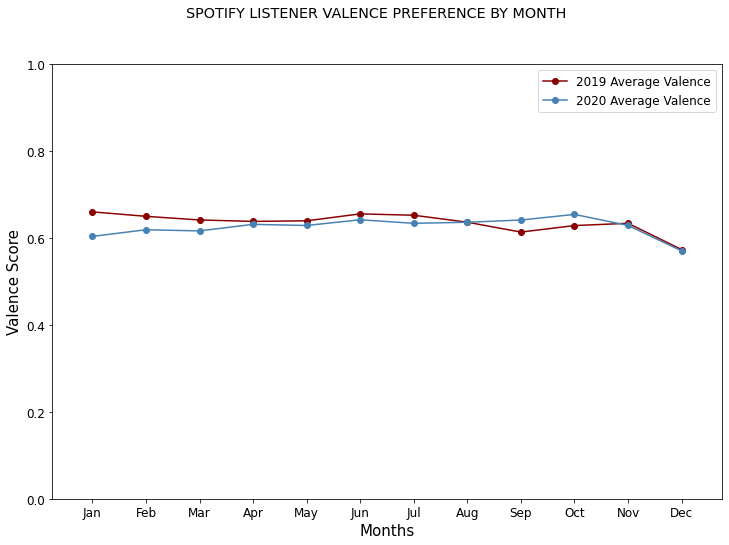

In [21]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = pd.DataFrame(country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019])

valence_2020 = pd.DataFrame(country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020])
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH')         # Set up main title

y_axis = valence_2019['Valence']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence'], label="2019 Average Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence'], label="2020 Average Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [22]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'Germany']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
29243,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947
29244,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947
29245,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947
29246,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947
29247,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947


In [23]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = pd.DataFrame(country_covid_df[country_covid_df.date.str.contains(r'2020.*')])

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
29243,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,
29244,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,
29245,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,
29246,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,
29247,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,


In [25]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
29243,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,1
29244,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,1
29245,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,1
29246,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,1
29247,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29578,DEU,Europe,Germany,2020-12-27,1658639.0,12399.0,20525.286,30297.0,351.0,556.714,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,12
29579,DEU,Europe,Germany,2020-12-28,1672643.0,14004.0,19775.000,31145.0,848.0,576.429,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,12
29580,DEU,Europe,Germany,2020-12-29,1692109.0,19466.0,17391.143,32267.0,1122.0,595.857,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,12
29581,DEU,Europe,Germany,2020-12-30,1741153.0,49044.0,19574.857,33230.0,963.0,617.286,...,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,12


In [26]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,1,5.0
1,2,74.0
2,3,71729.0
3,4,91201.0
4,5,20401.0
5,6,12008.0
6,7,14981.0
7,8,34403.0
8,9,48111.0
9,10,238877.0


In [28]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")
country_covid_valence_df = country_covid_valence_df.rename(columns={"new_cases":"New Cases"})
country_covid_valence_df

,Month,Valence,New Cases
0,1,0.603438,5.0
1,2,0.618662,74.0
2,3,0.616047,71729.0
3,4,0.631100,91201.0
4,5,0.628462,20401.0
5,6,0.641646,12008.0
6,7,0.633468,14981.0
7,8,0.635894,34403.0
8,9,0.641026,48111.0
9,10,0.653963,238877.0


In [29]:
# Add a new cases per million column

country_polulation = 83000000  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence,New Cases,New Cases Per Million
0,1,0.603438,5.0,0.060241
1,2,0.618662,74.0,0.891566
2,3,0.616047,71729.0,864.204819
3,4,0.631100,91201.0,1098.807229
4,5,0.628462,20401.0,245.795181
5,6,0.641646,12008.0,144.674699
6,7,0.633468,14981.0,180.493976
7,8,0.635894,34403.0,414.493976
8,9,0.641026,48111.0,579.650602
9,10,0.653963,238877.0,2878.036145


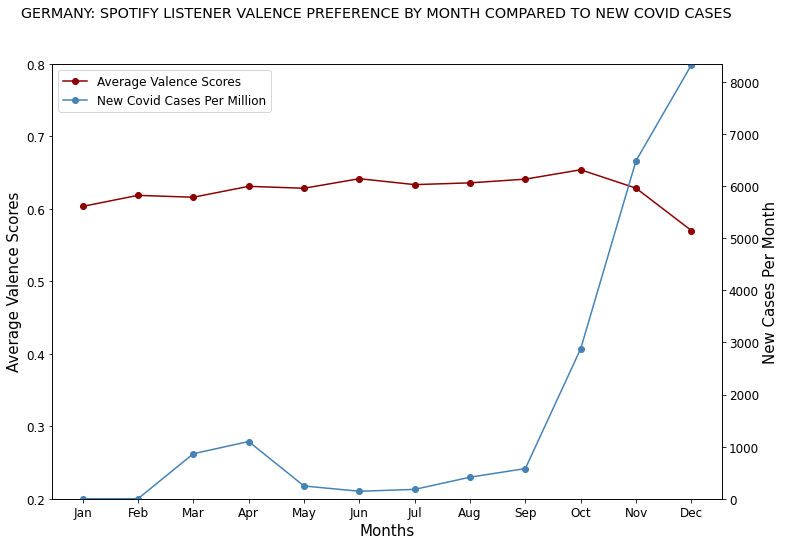

In [31]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('GERMANY: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence']
ax1.plot(months, ax1_ydata, label="Average Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()


In [32]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

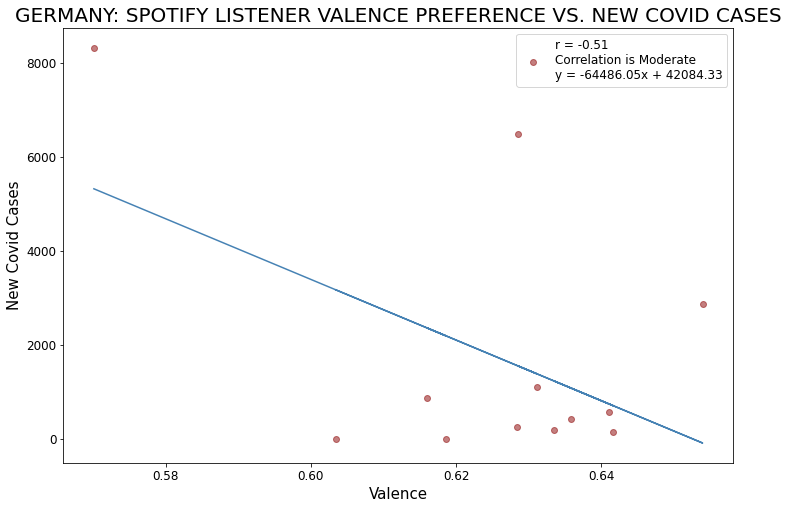

In [33]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('GERMANY: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"Valence")                                               # Set x axis label for subplot                  
plt.ylabel(f"New Covid Cases")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()